In [134]:
import numpy as np
from signal_functions import piecewise_linear_signal
from fourier import compute_fourier_coeff
import matplotlib.pyplot as plt

Code to understand how to the compute Fourier coefficients of a function in python. 

Use peiord equal to the sampling interval!

In [135]:
# First, the periodic signal from which we want to compute the Fourier coefficients
# Fourier coefficients will be automatically the same as number of samples

period = 2  # period of the signal
my_signal = piecewise_linear_signal  # signal function
n_samples = 2**7  # number of points in the grid

t_left = 0
t_right = 2
time_interval = t_right - t_left  # time interval of the signal

time_grid, dt = np.linspace(t_left, t_right, n_samples,  retstep=True)  # time grid


signal_eval = my_signal(input_points=time_grid,period =period)

freqs = np.fft.fftfreq(n_samples, d=time_interval/n_samples) # frequencies

### Continuous Fourier Series (Integral)

For a periodic function $ f(t) $ with period $ T $ the Fourier series representation (continuous case) expresses $ f(t) $ as a sum of complex exponentials:
$$
f(t) = \sum_{n=-\infty}^{\infty} c_n e^{i \frac{2 \pi n}{T} t}
$$

where the Fourier coefficients $ c_n $ are calculated by integrating over one period:
$$
c_n = \frac{1}{T} \int_0^T f(t) e^{-i \frac{2 \pi n}{T} t} \, dt
$$

This integral computes the "weight" of each frequency component $ n $ with $ T $ defining the fundamental frequency $ \frac{1}{T} $.

### Discrete Fourier Transform (DFT) as a Discretized Integral

When working with sampled data, we approximate $ f(t) $ by sampling it at $ N $\) equally spaced points over the interval $ [0, T) $, with sampling interval $\Delta t = \frac{T}{N} $:
$$
f[0], f[1], \dots, f[N-1]
$$

This discretization replaces the integral with a sum over $ N $ samples. The Fourier series coefficients $ c_n $ then become the **Discrete Fourier Transform (DFT)** coefficients $ F[k] $, which are given by:
$$
F[k] = \sum_{n=0}^{N-1} f[n] e^{-i \frac{2 \pi k n}{N}}
$$

where:
- $ k = 0, 1, 2, \dots, N-1 $ represents the discrete frequency indices.
- The frequency associated with each $ k $-th component is $ f_k = \frac{k}{T} $.


NOTE:  When you calculate Fourier coefficients analytically with an integral over one period, you’re typically computing the amplitude of the frequency components as a whole (combining contributions from both positive and negative frequencies).

Therefore, the FFT output needs to be divided by 2 to match the analytically computed coefficients, which assume amplitudes for the entire frequency component rather than splitting it across positive and negative parts.

$$
c_k \approx \frac{T}{N} \times 
\begin{cases} 
      F[0] & \text{for } k = 0, \\
      \frac{F[k]}{2} & \text{for } k = 1, \dots, N/2 - 1.
   \end{cases}
$$

In [136]:
#Compute Fourier coefficients using numpy.fft.fft
fft_fourier_coeff = compute_fourier_coeff(signal_eval, time_interval)  # Fourier coefficients scaled by the number of samples and multiplied the interval T
ifft_reconstructed_signal = np.fft.ifft(fft_fourier_coeff) * (n_samples / time_interval)  # scale by (n_samples / period)


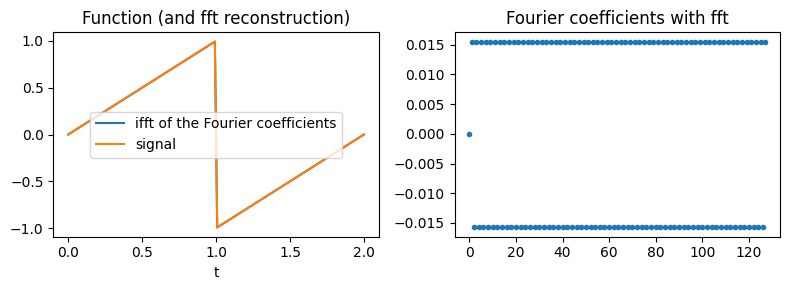

In [137]:
#plot the inverse Fourier transform of the Fourier coefficients, and the Fourier coefficients

#we plot two subplots, one with the function and the reconstructed function, and one with the Fourier coefficients:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

ax1.plot(time_grid, ifft_reconstructed_signal , label="ifft of the Fourier coefficients")  
ax1.plot(time_grid, signal_eval, label="signal")
ax2.plot(fft_fourier_coeff, '.')
ax1.set_xlabel("t")
ax1.set_title("Function (and fft reconstruction)")
ax2.set_title('Fourier coefficients with fft')
ax1.legend()
plt.tight_layout()


In [138]:
imag_part = np.imag(fft_fourier_coeff)
print(np.max(np.abs(imag_part))) 

0.6314801879776694


In [139]:
# use scipy integrate to integrate a function from 0 to T
from scipy.integrate import quad


# Now, let's compute the Fourier coefficients manually using integration

def coeff_quad(n, signal, period):
    # Integrate real and imaginary parts separately and combine
    real_part = quad(lambda t: np.real(signal(t,period) * np.exp(-1j * 2 * np.pi * n * t / period)), 0, period)[0]
    imag_part = quad(lambda t: np.imag(signal(t,period) * np.exp(-1j * 2 * np.pi * n * t / period)), 0, period)[0]
    return (real_part + 1j * imag_part) / period



# Initialize coefficients array and compute manually
analytical_fourier_coeff = np.zeros(n_samples, dtype=complex)
analytical_fourier_coeff[0] = coeff_quad(0, my_signal, period=period)  #  DC component
for i in range(1, n_samples // 2):
    analytical_fourier_coeff[i] = coeff_quad(i, my_signal,period=period)
    analytical_fourier_coeff[-i] = np.conj(analytical_fourier_coeff[i])  # Ensure symmetry for real signals


def inverse_fourier(t, coeff, period):
    # Generate frequency indices that include negative frequencies
    aux = np.fft.fftfreq(coeff.size, d=period/coeff.size)
    
    # Perform the inverse Fourier summation
    return (coeff * np.exp(1j * 2 * np.pi * aux * t)).sum()



# Evaluate reconstructed function over the time grid
analytical_reconstructed_signal = np.array([inverse_fourier(t, analytical_fourier_coeff, period = period) for t in time_grid]) 


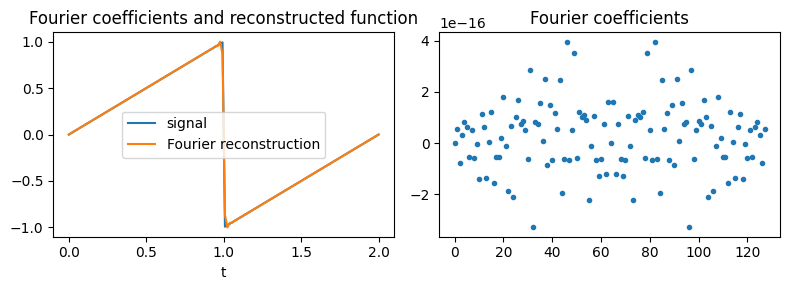

In [140]:
# Plot the analitycally function and the Fourier coefficients
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

ax1.plot(time_grid, signal_eval, label="signal")
ax1.plot(time_grid, analytical_reconstructed_signal, label="Fourier reconstruction")
ax2.plot(analytical_fourier_coeff, '.')
ax1.set_xlabel("t")
ax1.set_title("Fourier coefficients and reconstructed function")
ax2.set_title('Fourier coefficients')
ax1.legend()
plt.tight_layout()

In [141]:
# relate fft computed coefficients with the analytical ones
scaled_fft_coeff = np.zeros(n_samples, dtype=complex)
scaled_fft_coeff[1:] = fft_fourier_coeff[1:] / 2
    

False

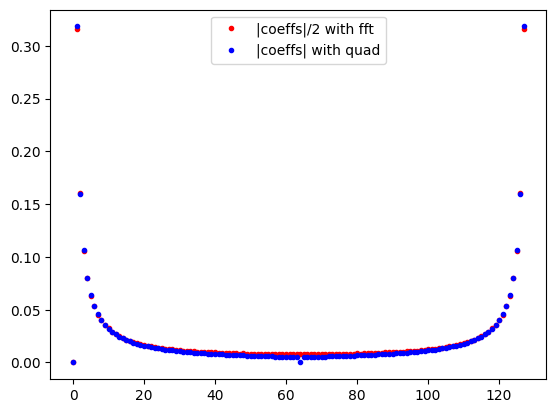

In [142]:
# Compare the coefficients obtained with the two methods:

plt.plot( np.abs(scaled_fft_coeff), '.', color='r', label='|coeffs|/2 with fft' )
plt.plot( np.abs(analytical_fourier_coeff), '.', color='b', label='|coeffs| with quad' )
plt.legend()

#check if the coefficients are the same (up to numerical precision)
np.allclose(fft_fourier_coeff, analytical_fourier_coeff[:fft_fourier_coeff.size], rtol=1e-2, atol=1e-1)   



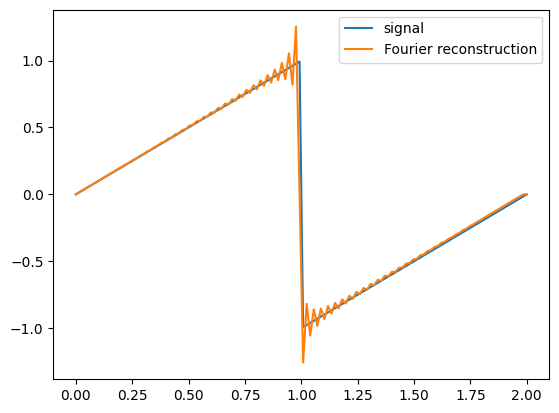

In [143]:
#Reconstruct the signal using coefficients computed with fft scaled

f_reconstructed =  np.array([inverse_fourier(s,scaled_fft_coeff, period = period) for s in time_grid])

plt.plot(time_grid, signal_eval, label="signal")
plt.plot(time_grid, f_reconstructed , label = 'Fourier reconstruction')
plt.legend()


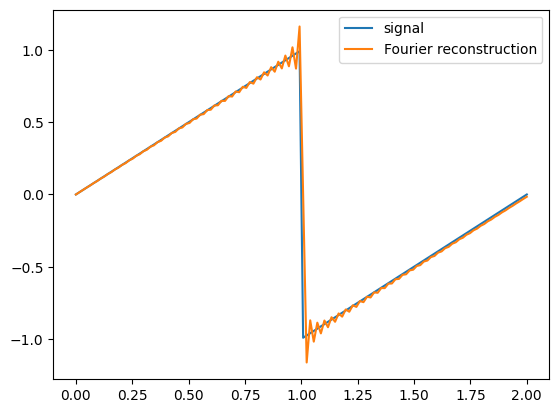

In [144]:
# vice versa, reconstruct the signal via ifft using coefficients computed with quad
f_reconstructed = np.fft.ifft(analytical_fourier_coeff) * 2 *(n_samples / time_interval)  # scale by (n_samples / period) * 2!!

plt.plot(time_grid, signal_eval, label="signal")
plt.plot(time_grid, f_reconstructed , label = 'Fourier reconstruction')
plt.legend()

